In [51]:
import pandas as pd
from wordcloud import WordCloud
import numpy as np
from PIL import Image
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime as dt

# Shark Attack Analysis (EDA)

This notebook will demonstrate the final part of the R-ETL-A process. Analysis! 

This is where the fun begins. The data has been extracted-transformed-loaded into a useable state and this can be done multiple times with rationalisation of new data. Now the analysis which will also be reproducible will begin.

In [2]:
df = pd.read_csv('data/master.csv')
df.drop('Unnamed: 0', inplace=True, axis=1)

df.head(5)

,CaseNumber,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,...,Fatal (Y/N),Time,Species,Investigator or Source,pdf,href formula,href,Case Number.1,Case Number.2,original order
0,1998.05.29.a,1998-05-29 00:00:00,1998.0,Unprovoked,SOUTH AFRICA,Eastern Cape Province,Jeffreys Bay,Body boarding,Jan-Henrick Opperman,M,...,N,Early afternoon,Unidentified,"A. Gifford, GSAF",1998.05.29.a-Opperman.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,1998.05.29.a,1998.05.29.a,4049.0
1,1895.11.16,1895-11-16 00:00:00,1895.0,Unprovoked,AUSTRALIA,New South Wales,Jervis Bay,Fishing,Edward Bailey,M,...,Y,NaN,NaN,"West Australian, 11/19/1895",1895.11.16-Bailey.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,1895.11.16,1895.11.16,621.0
2,1965.08.30,1965-08-30 00:00:00,1965.0,Invalid,PHILIPPINES,Unknown,"Grounded off Scarborough Shoals, 150 miles nor...","Arsinoe, a French tanker",French seaman,M,...,Y,NaN,Shark involvement not confirmed,"Manila Daily Bulletin, 9/3/1965; SAF Case #1388",1965.08.30-Arsinoe.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,1965.08.30,1965.08.30,2624.0
3,1844.07.20.,1844-07-20 00:00:00,1844.0,Unprovoked,NAMIBIA,Unknown,NaN,Boat capsized,a seaman from HMS Isis,M,...,Y,NaN,NaN,"Colonial Times, 5/24/1845",1844.07.20-Isis-seaman.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,1844.07.20.,1844.07.20.,229.0
4,2012.02.25,2012-02-25 00:00:00,2012.0,Unprovoked,AUSTRALIA,New South Wales,Broughton Island,Fishing,male,M,...,N,16h00,Grey nurse shark,"B. Smee, Newcastle Herald, 2/27/2012",2012.02.25-BroughtonIslandFisherman.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2012.02.25,2012.02.25,5418.0


## Injury Data Word Cloud - What are the most common words used in injury reports?

Are their common words used? What are those words? How can those words be represented?

In [16]:
def build_wordcloud(stopwords:list, image_path:str, text:str, title:str)-> go.Figure:
    '''
    Build a wordcloud that meets the same styling requirements in a shape based on an image
    
    :param stopwords: List of stopwords to remove
    :param image_path: Path to the image to use as a shape
    :param text: Text to use in the wordcloud
    :param title: Title of the wordcloud
    
    :returns: Word cloud plotly figure  
    '''
    
    # read in base image 
    mask = np.array(Image.open(image_path))

    # set up word cloud options 
    wc = WordCloud(stopwords=stopwords,
                   mask=mask, background_color="white",
                   max_words=2000, max_font_size=200,
                   random_state=42, width=mask.shape[1],
                   height=mask.shape[0])

    # generate cloud based on string of injury col
    words = wc.generate(text)

    # build image figure of cloud 
    fig = px.imshow(words, title=title)

    # update the fonts used in chart labels
    fig.update_layout(
        title_font_family="Arial",
        title_font_color="black",
    )

    # figure does not need axis
    fig.update_layout(coloraxis_showscale=False)
    fig.update_xaxes(showticklabels=False)
    fig.update_yaxes(showticklabels=False)
    
    return fig


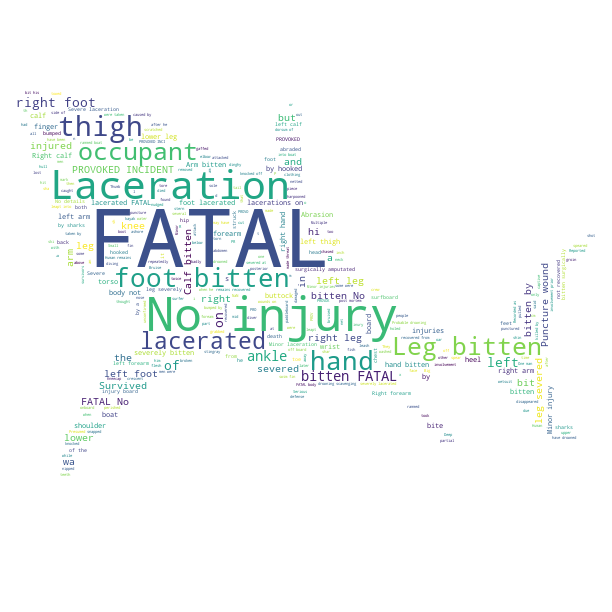

In [18]:
# set up stop words 
STOPWORDS = ['shark', 'to']

fig = build_wordcloud(stopwords=STOPWORDS ,
                      image_path='img.jpeg', 
                      text=df['Injury'].to_string(), 
                      title='Wordcloud of most common shark attack injury statements')

fig.write_image('wordcloud.jpeg')
fig.show()

## Provocation by Country

How does provocation factor in? Are some areas more dangerous regardless of how provoked the sharks are? Or is the distribution of attacks by provocation status equal around the world?

In [37]:
def produce_ranked_bar(data:pd.DataFrame, y:str, x:str, color:str, labels:dict, limit:int, title:str)->go.Figure:
    '''
    Produce a ranked bar chart with set stylings and able to take multiple inputs
    
    :param data: Data frame to produce the chart from
    :param y: The y value to count for the chart
    :param x: The x value to plot
    :param color: The color value to disaggregate
    :param labels: The labels to use in the chart
    :param limit: The limit to show only x values in the chart
    :param title: The title of the chart 
    
    :returns: The ranked bar chart plotly Figure
    '''
    # decide whether there is only one or two groupings
    if color: 
        groupby = [x, color]
    else:
        groupby = [x]
    
    # perform grouping 
    bar_data = data.groupby(['Country', 'Type']).count().reset_index()
    
    # rank the data so that only top x are shown
    ranked = bar_data.sort_values('CaseNumber', ascending=False)
    top_twenty = ranked[x][:limit].tolist()
    ranked = ranked[ranked[x].isin(top_twenty)]
    
    # build the charts using the parameters
    if color:
        bar = px.bar(ranked, x=x, y=y, color=color, template='seaborn',
                    labels=labels, title=title)
    else:
        bar = px.bar(ranked, x=x, y=y, color=color, template='seaborn',
                    labels=labels, title=title)

    bar.update_layout(
        font_family="Arial",
        font_color="black")
    
    return bar

y = 'CaseNumber'
x = 'Country'
color = 'Type'
labels = labels={
    'Country': 'Country of attack',
    'CaseNumber': 'Count of attacks',
    'Type': 'Provocation'
}
limit = 20
title='Number of shark attacks by country and provocation status'

produce_ranked_bar(df, y, x, color, labels, limit, title).show()

## Fatalities over Time

How many fatalities have been recorded? How has this varied overtime? How many attacks go undated?

In [82]:
# make the subplot
subplot = make_subplots(rows=1, cols=2, column_widths=[0.8, 0.2], shared_yaxes=True)

# select the data needed (fatalities only, after 1920)
fatalities = df[df['Fatal (Y/N)'] == 'Y']
fatalities = fatalities[(fatalities['Year']>1920) | (fatalities['Year']==0)]

# aggregate the data by year
dated_aggregate = fatalities.groupby(['Year']).CaseNumber.count().reset_index()

# split into the known and unknown aggregates
unknown_aggregate = dated_aggregate[dated_aggregate['Year']==0]
dated_aggregate = dated_aggregate[dated_aggregate['Year']!=0]

# add the known date trace in the first column
subplot.add_trace(go.Scatter(x=dated_aggregate['Year'], y=dated_aggregate['CaseNumber'], 
                             mode='lines', name='Fatalities - Dated'), row=1, col=1)

# add the unknown date trace in the second column
subplot.add_trace(go.Bar(x=['Unknown'],y=unknown_aggregate['CaseNumber'], name='Fatalities - Date Unknown'), row=1, col=2)

# update the figure to fix the x axis of plot one, add a title, and add theme options
subplot.update_layout(xaxis1=dict(range=[1918,2022]), 
                      title='Number of fatalities by date',
                     font_family="Arial", font_color="black", template='seaborn')

subplot.show()